In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr
from rioxarray.exceptions import NoDataInBounds
from rioxarray.merge import merge_arrays
import gc
from datetime import datetime

NOTE:

The biggest plot hole here is that we are normalising to the global mean for night and day seperately. The problem is that they are only vaguely. What we need to do to reduce bias is to normalise to a reference day and night image (via PIF-LRM) which are connected as best as possible spatiotemporally, so that the normalisation is actually meaningful. The problem, however, with normalising to a reference day and night image is that some of these images don't have a relationship since there is no overlap in the actual data

In [ ]:
target_crs = "EPSG:3577" # Aus Albers Equal-Area
bbox = gpd.read_file("bbox_sm.gpkg")

# Compositing
- Creating a seasonal summer average, using the median which is robust to outliers
- Normalisation / data centering
  - Primes the data for entry into CNN
  - Preserves the strcutre of the UHI, and the difference between day and night
  - NOTE: Removes the ability to detect differences between days!!

## Normalisation

In [ ]:
in_dir = Path('out/DAY')
raster_files = sorted(in_dir.glob("*_LSTC.tif"))
print(f"{len(raster_files)} daytime files")

aoi = gpd.read_file("bbox_sm.gpkg")

11 daytime files


In [ ]:
# Flushes the memory before dealing with big datasets
for var in ["da", "da_clip", "da_reproj", "da_list", "template", "aligned_da", "aligned", "stack", "median"]:
    if var in globals():
        print(f"Flushing {var}")
        del globals()[var]

gc.collect()

Flushing da
Flushing da_clip
Flushing da_reproj
Flushing da_list


7960

In [ ]:
da_list = []

for f in raster_files:
    print(f"Opening: {f.name}")
    da = rxr.open_rasterio(f, masked=True, chunks = {"x":1024, "y":1024}).squeeze(drop = True)

    # Reassert clipping since dealing with big datasets

    aoi_src = aoi.to_crs(da.rio.crs)
    da_clip = da.rio.clip(
        aoi_src.geometry,
        aoi_src.crs,
        drop=True,
    ).squeeze(drop=True)

    del da

    # Reassert reprojection

    resx, resy = da_clip.rio.resolution()
    da_reproj = da_clip.rio.reproject(
        target_crs,
        resolution = (resx, resy)
    )

    del da_clip

    da_list.append(da_reproj)

Opening: LC08_L1TP_089083_20191106_20200825_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_089083_20200109_20200823_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_089083_20200125_20200823_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_089084_20191106_20200825_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090083_20191113_20200825_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090083_20191215_20201022_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090083_20191231_20200824_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090083_20200201_20200823_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090083_20200217_20200823_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090084_20191113_20200825_02_T1_B10_LSTC.tif
Opening: LC08_L1TP_090084_20191215_20201022_02_T1_B10_LSTC.tif


MemoryError: Unable to allocate 2.57 GiB for an array with shape (24547, 28080) and data type float32

In [ ]:
template = merge_arrays(da_list)

aligned = []

for da in da_list:
    aligned_da = da.rio.reproject_match(template)
    aligned.append(aligned_da)

stack = xr.concat(aligned, dim="time")

summer_mean_lst = stack.median("time", skipna=True)

out_path = Path('out/DAY/summer_avg_LST_sm.tif')
summer_mean_lst.rio.to_raster(out_path)

print(stack)

In [ ]:
# Normalisation

scene_medians = stack.median(dim=("y", "x"), skipna = True)
global_median = scene_medians.median(dim="time")
normalised_stack = stack - (scene_medians - global_median)

normalised_median = normalised_stack.median("time", skipna=True)

out_path = Path('out/DAY/LSTC_median_sm_21112025.tif')
normalised_median.rio.to_raster(out_path)

NameError: name 'stack' is not defined

In [17]:
in_path = Path('out/DAY/LSTC_median_sm.tif')
out_path = Path('out/DAY/LSTK_median_sm.tif')

with rasterio.open(in_path) as src:
    arr_c = src.read(1).astype("float32")

    arr_k = arr_c + 273.15

    meta = src.meta.copy()
    meta.update({
        "dtype": "float32",
        "nodata": np.nan
    })

    with rasterio.open(out_path, "w", **meta) as dst:
        arr_out = np.where(np.isnan(arr_k), nodata, arr_k)
        dst.write(arr_out.astype("float32"), 1)


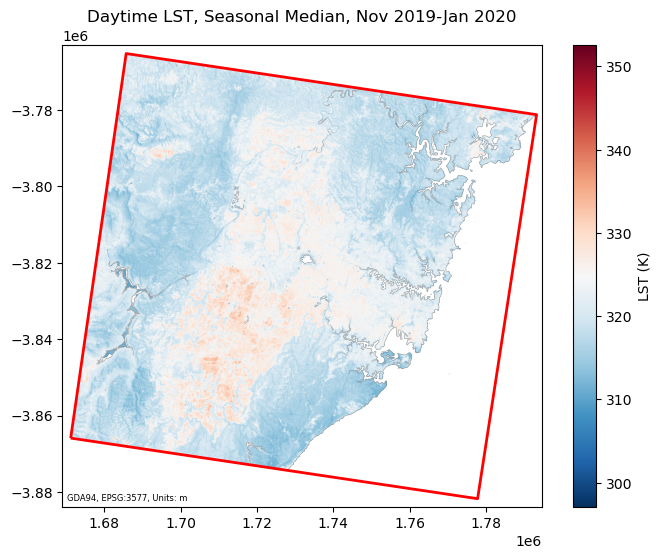

Min: 297.06732 C
Max: 352.55273 C
Mean: 320.57614 C
Std: 3.9837554 C


In [20]:
# Visualisation
out_path = Path('out/DAY/LSTK_median_sm.tif')
bbox = "bbox_sm.gpkg"

with rasterio.open(out_path) as src:

    fig, ax = plt.subplots(figsize=(8,6))
    im = show(
        src,
        ax=ax,
        cmap='RdBu_r',
        )
    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    cbar.set_label("LST (K)")
    plt.title("Daytime LST, Seasonal Median, Nov 2019-Jan 2020")

    bbox = gpd.read_file(bbox)
    bbox_reproj = bbox.to_crs(src.crs)
    
    bbox_reproj.boundary.plot(ax = ax, edgecolor= "red", linewidth = 2)

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.show()

print("Min:", np.nanmin(arr), "C")
print("Max:", np.nanmax(arr), "C")
print("Mean:", np.nanmean(arr), "C")
print("Std:", np.nanstd(arr), "C")

# Nighttime

In [ ]:
# Flushes the memory before dealing with big datasets
for var in ["da", "da_clip", "da_reproj", "da_list", "template", "aligned_da", "aligned", "stack", "median"]:
    if var in globals():
        print(f"Flushing {var}")
        del globals()[var]

gc.collect()

Flushing da
Flushing da_clip
Flushing da_reproj
Flushing da_list
Flushing template
Flushing aligned_da
Flushing aligned
Flushing stack


20013

In [ ]:
in_dir = Path("out/NIGHT")
raster_files = sorted(in_dir.glob("*_LSTC.tif"))
print(len(raster_files), "files")

aoi = gpd.read_file("bbox_sm.gpkg")

4 files


In [ ]:
da_list = []

for f in raster_files:
    print(f"Opening: {f.name}")
    da = rxr.open_rasterio(f, masked=True).squeeze(drop = True)

    # Reassert clipping since dealing with big datasets

    aoi_src = aoi.to_crs(da.rio.crs)
    da_clip = da.rio.clip(
        aoi_src.geometry,
        aoi_src.crs,
        drop=True,
    ).squeeze(drop=True)

    # Reassert reprojection

    resx, resy = da_clip.rio.resolution()
    da_reproj = da_clip.rio.reproject(
        target_crs,
        resolution = (resx, resy)
    )

    da_list.append(da_reproj)

Opening: LC08_L1GT_208160_20191226_20200824_02_T2_B10_LSTC.tif
Opening: LC08_L1GT_208161_20191226_20200824_02_T2_B10_LSTC.tif
Opening: LC08_L1GT_209160_20191217_20201023_02_T2_B10_LSTC.tif
Opening: LC08_L1GT_209161_20191217_20201023_02_T2_B10_LSTC.tif


In [ ]:
template = merge_arrays(da_list)

aligned = []

for da in da_list:
    aligned_da = da.rio.reproject_match(template)
    aligned.append(aligned_da)

stack = xr.concat(aligned, dim="time")

summer_mean_lst = stack.median("time", skipna=True)

out_path = Path('out/NIGHT/summer_avg_LST_sm.tif')
summer_mean_lst.rio.to_raster(out_path)

print(stack)

<xarray.DataArray (time: 4, y: 4034, x: 4189)> Size: 270MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, na

In [ ]:
scene_medians = stack.median(dim=("y", "x"), skipna = True)
global_median = scene_medians.median(dim="time")
normalised_stack = stack - (scene_medians - global_median)

normalised_median = normalised_stack.median("time", skipna=True)

out_path = Path('out/NIGHT/LSTC_median_sm.tif')
normalised_median.rio.to_raster(out_path)

In [23]:
in_path = Path('out/NIGHT/LSTC_median_sm.tif')
out_path = Path('out/NIGHT/LSTK_median_sm.tif')

with rasterio.open(in_path) as src:
    arr_c = src.read(1).astype("float32")

    arr_k = arr_c + 273.15

    meta = src.meta.copy()
    meta.update({
        "dtype": "float32",
        "nodata": np.nan
    })

    with rasterio.open(out_path, "w", **meta) as dst:
        arr_out = np.where(np.isnan(arr_k), nodata, arr_k)
        dst.write(arr_out.astype("float32"), 1)

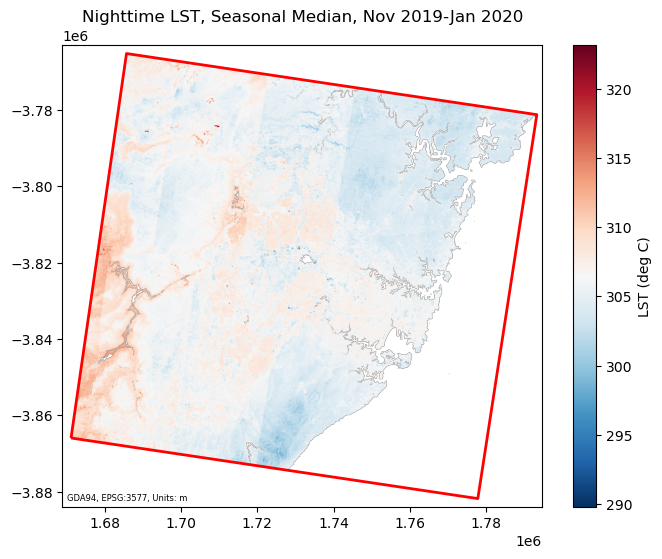

Min: 289.78955 C
Max: 347.75983 C
Mean: 305.9838 C
Std: 1.9491978 C


In [27]:
# Visualisation
bbox_shp = "bbox_sm.gpkg"
out_path = Path('out/NIGHT/LSTK_median_sm.tif')

with rasterio.open(out_path) as src:
    arr = src.read(1)
    fig, ax = plt.subplots(figsize=(8,6))
    im = show(
        src,
        ax=ax,
        cmap='RdBu_r',
        vmax = 323.15
        )
    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    cbar.set_label("LST (deg C)")
    plt.title("Nighttime LST, Seasonal Median, Nov 2019-Jan 2020")

    bbox_gdf = gpd.read_file(bbox_shp)
    if bbox_gdf.crs != src.crs:
        bbox_gdf = bbox_gdf.to_crs(src.crs)
    
    bbox_gdf.boundary.plot(ax = ax, edgecolor= "red", linewidth = 2)

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.show()

arr[arr == -9999] = np.nan

print("Min:", np.nanmin(arr), "C")
print("Max:", np.nanmax(arr), "C")
print("Mean:", np.nanmean(arr), "C")
print("Std:", np.nanstd(arr), "C")

In [ ]:
# Mask by water of the day
mask_src = 'out/DAY/LSTC_median_sm.tif'
target_src = 'out/NIGHT/LSTC_median_sm.tif'

out_path = 'out/NIGHT/LSTC_median_sm_m.tif'

mask = rxr.open_rasterio(mask_src).squeeze()
data = rxr.open_rasterio(target_src).squeeze()

if mask.rio.crs != data.rio.crs:
    data = data.rio.reproject(mask.rio.crs)

data_match = data.rio.reproject_match(mask)

masked_finite = np.isfinite(mask)
masked = data_match.where(masked_finite)

masked.rio.to_raster(out_path)

print("BEFORE")
print("  Mask shape:", mask.shape, "CRS:", mask.rio.crs)
print("  Data shape:", data.shape, "CRS:", data.rio.crs)

print("\nAFTER reproject_match")
print("  Mask shape:", mask.shape)
print("  Data_match shape:", data_match.shape)
print("  Mask transform:", mask.rio.transform())
print("  Data_match transform:", data_match.rio.transform())

print("\nFinite pixels in mask:", int(masked_finite.sum()))
print("Finite pixels in masked:", int(np.isfinite(masked).sum()))

BEFORE
  Mask shape: (4033, 4185) CRS: EPSG:3577
  Data shape: (4034, 4189) CRS: EPSG:3577

AFTER reproject_match
  Mask shape: (4033, 4185)
  Data_match shape: (4033, 4185)
  Mask transform: | 30.00, 0.00, 1669040.13|
| 0.00,-30.00,-3762983.24|
| 0.00, 0.00, 1.00|
  Data_match transform: | 30.00, 0.00, 1669040.13|
| 0.00,-30.00,-3762983.24|
| 0.00, 0.00, 1.00|

Finite pixels in mask: 9497566
Finite pixels in masked: 9491110
